In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import roc_auc_score
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
train = pd.read_csv('/content/gdrive/My Drive/Tinkoff_risk_management/train.csv',sep=',')
data_train = train.iloc[:, 1:]
target_train = train.iloc[:, 0]

val = pd.read_csv('/content/gdrive/My Drive/Tinkoff_risk_management/val.csv',sep=',')
data_val = val.iloc[:, 1:]
target_val = val.iloc[:, 0]

test = pd.read_csv('/content/gdrive/My Drive/Tinkoff_risk_management/test.csv',sep=',')
data_test = test.iloc[:, 1:]
target_test = test.iloc[:, 0]

y_train = (target_train == 'Yes').astype(int)
y_val = (target_val == 'Yes').astype(int)
y_test = (target_test == 'Yes').astype(int)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (1,5) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
def make_bucket(df, feature, n=100):
    '''функция, бьющая на бакеты(по умолчанию 100 точек)'''
    return df.assign(bucket = np.ceil(df[feature].rank(pct=True) * n))

#РЕАЛИЗАЦИЯ WOE_LINE

In [ ]:
def woe_line(x, y, feature_name, target_name, n_buckets=20):
    """ Строит график зависимости WoE
    x - параметр, от которого стоит искать зависимость
    y - метки класса (0 / 1)
    n_buckets - количество бинов для вещественного признака
    feature_name, target_name - подписи к графику
    """
    df = pd.DataFrame()
    df[feature_name], df[target_name] = x, y
    all_0, all_1 = list(df[target_name].value_counts())
    target_log = np.log(all_1 / all_0)

    df = make_bucket(df, feature_name, n_buckets)

    bucket_numbers = df['bucket'].unique()

    feature_mean, woe, iv = [], [], 0

    for i in range(1, n_buckets+1):
      if i in bucket_numbers:
        feature_mean.append(df.loc[df['bucket'] == i][feature_name].mean())
        backet_0, backet_1 = list(df.loc[df['bucket'] == i][target_name].value_counts())
        woe_value = np.log(backet_1 / backet_0) - target_log
        woe.append(woe_value)
        iv = iv + woe_value * (backet_1 / all_1 - backet_0 / all_0)

    model_1 = LinearRegression()
    trans_feature_mean = (np.array(feature_mean)).reshape(-1, 1)
    model_1.fit(trans_feature_mean, woe)
    pred_1 = model_1.predict(trans_feature_mean)

    #смотрим, при каком значении признака woe = 0
    for i in range(len(woe)-1):
      if (woe[i] < 0 and woe[i+1] > 0) or (woe[i] > 0 and woe[i+1] < 0):
        left_bound_ind, right_bound_ind = i, i+1
    xp = [woe[left_bound_ind], woe[right_bound_ind]]
    fp = [feature_mean[left_bound_ind], feature_mean[right_bound_ind]]

    if woe[left_bound_ind] > woe[right_bound_ind]:
      xp = [woe[right_bound_ind], woe[left_bound_ind]]
      fp = [feature_mean[right_bound_ind], feature_mean[left_bound_ind]]
    woe_equal_0 = round(np.interp(0, xp, fp), 4)

    model_2 = LogisticRegression()
    x_trans = (np.array(x)).reshape(-1, 1)
    y_trans = (np.array(y)).reshape(-1, 1)
    model_2.fit(x_trans, y_trans.ravel())
    pred_2 = model_2.predict_proba(x_trans)[:, 1]

    plt.figure(figsize=(18, 6))
    plt.grid(True)
    #отразим woe и интерполяцию относительно оси абсцисс, чтобы проще было сравнивать с реализацией из семинара
    plt.plot(feature_mean, [-i for i in woe], linestyle='dashed', color='red', label = 'woe')
    plt.plot(trans_feature_mean, [-i for i in pred_1], color='blue', label = 'interpolation')
    plt.xlabel(feature_name, fontsize=20)
    plt.ylabel('woe', fontsize=20)
    plt.legend()
    print(f"feature name : {feature_name}")
    print(f"target name : {target_name}")
    print(f"ROC AUC = {roc_auc_score(y, pred_2):.2f}")
    print(f"woe = 0 при {feature_name} = {woe_equal_0}")
    print(f"IV = {iv:.3f}")


In [ ]:
def woe_line_new(x, y, feature_name, target_name, n_buckets=20):
    """ Строит график зависимости WoE
    x - параметр, от которого стоит искать зависимость
    y - метки класса (0 / 1)
    n_buckets - количество бинов для вещественного признака
    feature_name, target_name - подписи к графику
    """
    df = pd.DataFrame()
    df[feature_name], df[target_name] = x, y
    all_0, all_1 = list(df[target_name].value_counts())
    target_log = np.log(all_1 / all_0)

    model = LogisticRegression(fit_intercept=True)
    model.fit((np.array(df[feature_name])).reshape(-1, 1), (np.array(df[target_name])).reshape(-1, 1))
    a_0 = model.intercept_[0]
    a_1 = model.coef_[0]

    woe = lambda x : a_0 + a_1 * x - target_log

    return fsolve(woe, df[feature_name].median()))



#ПРЕОБРАЗОВАНИЕ ПРИЗНАКОВ

In [ ]:
trans_features = [] # будем добавлять сюда преобразованные признаки

**Вещественные признаки:**

1. BMI - индекс массы
2. PhysicalHealth - сколько из последних 30 дней пациент чувствовал себя плохо
3. MentalHealth - сколько из последних 30 дней пациент чувствовал себя плохо физически
4. SleepTime - сколько спит в день

Посмотрим, где есть пропуски


In [ ]:
real_features = ['BMI', 'PhysicalHealth', 'MentalHealth', 'SleepTime']

data_train[real_features].isna().any()

BMI               False
PhysicalHealth    False
MentalHealth      False
SleepTime          True
dtype: bool

**BMI**

В индексе массы нет пропусков, но есть ячейки строчного типа, среди которых есть числа, записанные в виде строк, и диапазоны значений. В первом случае преобразуем строку в вещественное число, во втором - возьмём среднее значение из диапазона. 

In [ ]:
data_train['BMI_trans'] = data_train['BMI'].apply(lambda x : (sum([float(i) for i in x.split('-')]) / 2 if '-' in x else float(x)) if isinstance(x, str) else x)

BMI до линеаризации

feature name : BMI_trans
target name : HeartDisease
ROC AUC = 0.56
woe = 0 при BMI_trans = 26.3862
IV = 0.046


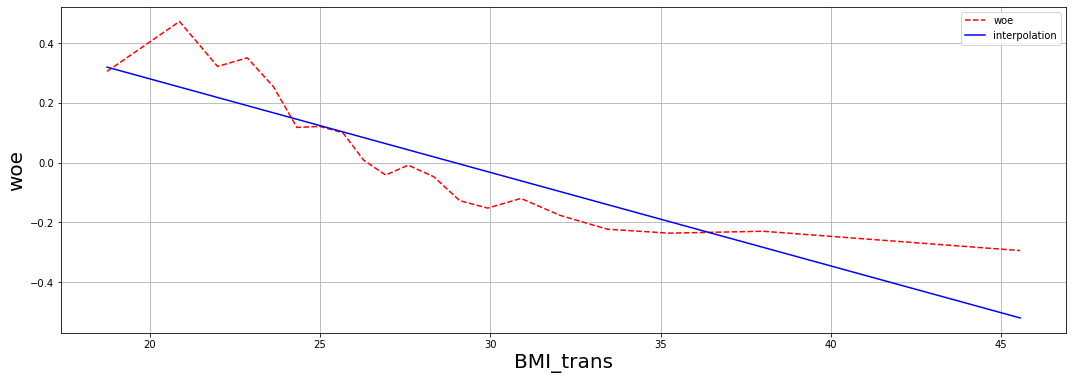

In [ ]:
woe_line(data_train['BMI_trans'], y_train, 'BMI_trans', 'HeartDisease')

In [ ]:
woe_line_new(data_train['BMI_trans'], y_train, 'BMI_trans', 'HeartDisease')

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


[28.79798652]


BMI после линеаризации

feature name : BMI_trans
target name : HeartDisease
ROC AUC = 0.56
woe = 0 при BMI_trans = 3.2727
IV = 0.045


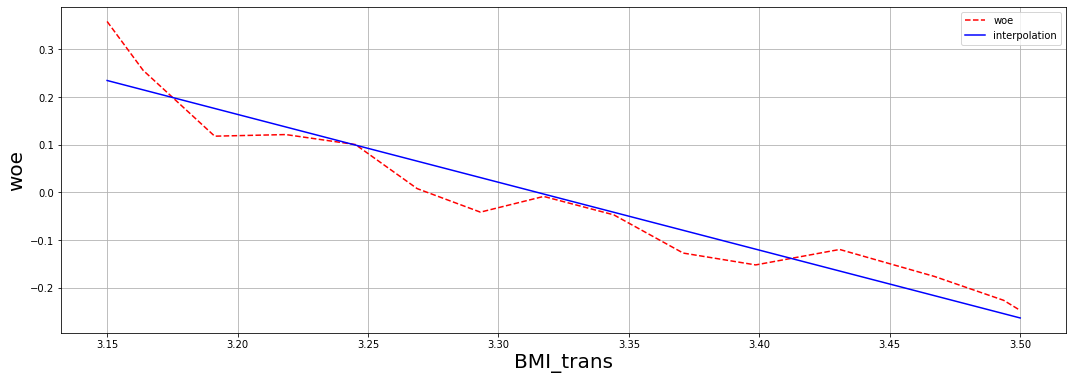

In [ ]:
woe_line(np.log(data_train['BMI_trans']).clip(3.15, 3.5), y_train, 'BMI_trans', 'HeartDisease')

data_train['BMI_linearized'] = np.log(data_train['BMI_trans']).clip(3.15, 3.5)

trans_features.append('BMI_linearized')

**PhysicalHealth**

В признаке нет пропусков, числа, записанные в виде строк, преобразуем в вещественный тип, есть одна ячейка = 'Fair', будем воспринимать это как пропуск, заменим её значением, где woe = 0.

PhysicalHealth до линеаризации

feature name : PhysicalHealth_trans
target name : HeartDisease
ROC AUC = 0.62
woe = 0 при PhysicalHealth_trans = 2.6037
IV = 0.275


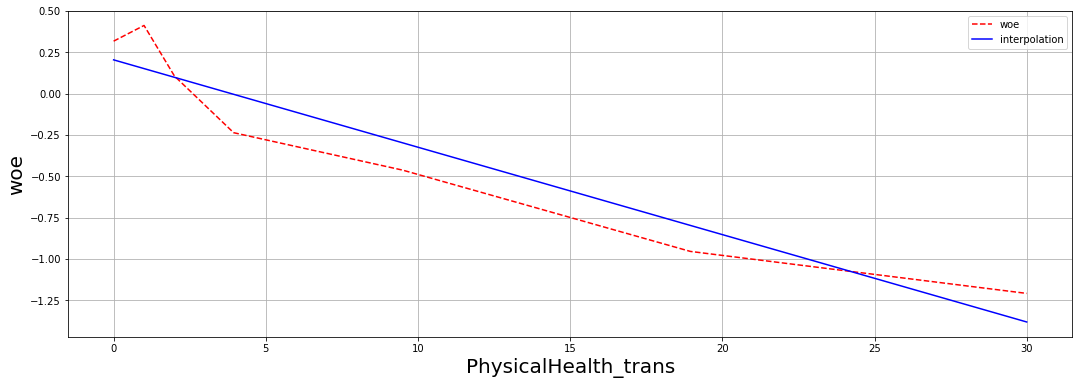

In [ ]:
data_train['PhysicalHealth_trans'] = data_train['PhysicalHealth'].apply(lambda x : (np.nan if x == 'Fair' else float(x)) if isinstance(x, str) else x)

nan_index = np.where(pd.isna(data_train['PhysicalHealth_trans']))[0][0]

woe_line(data_train['PhysicalHealth_trans'].dropna(), y_train.drop(index=nan_index), 'PhysicalHealth_trans', 'HeartDisease')

In [ ]:
data_train['PhysicalHealth_trans'] = data_train['PhysicalHealth_trans'].fillna(2.6037)

PhysicalHealth после линеаризации

feature name : PhysicalHealth_trans
target name : HeartDisease
ROC AUC = 0.62
woe = 0 при PhysicalHealth_trans = 0.8963
IV = 0.275


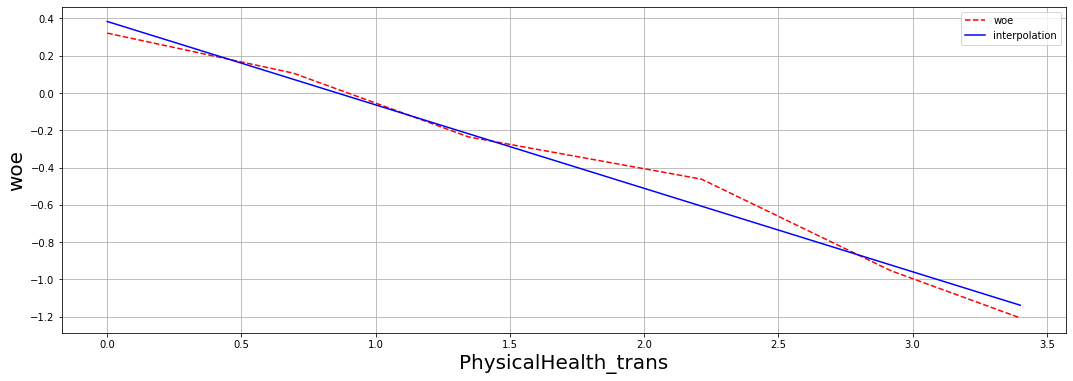

In [ ]:
woe_line(np.log(data_train['PhysicalHealth_trans'].clip(lower=1)), y_train, 'PhysicalHealth_trans', 'HeartDisease')

data_train['PhysicalHealth_linearized'] = np.log(data_train['PhysicalHealth_trans'].clip(lower=1))

trans_features.append('PhysicalHealth_linearized')

**MentalHealth**

Нет пропусков, все ячейки - числа

MentalHealth до линеаризации


feature name : MentalHealth
target name : HeartDisease
ROC AUC = 0.50
woe = 0 при MentalHealth = 15.1322
IV = 0.037


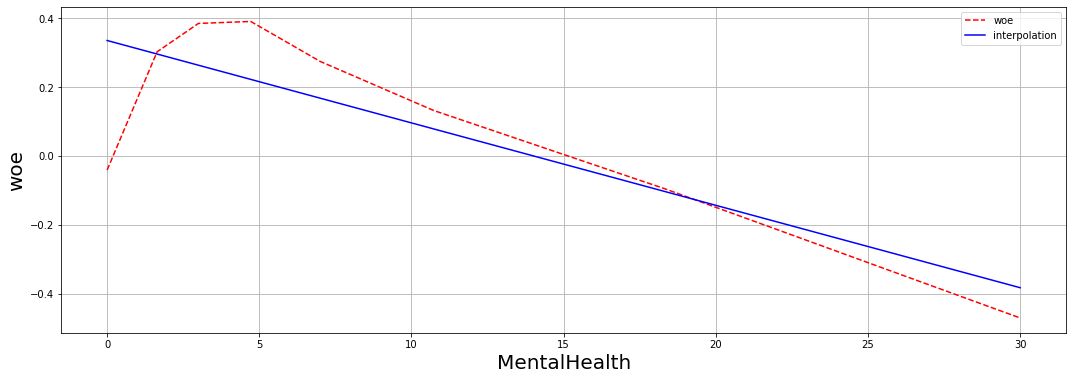

In [ ]:
woe_line(data_train['MentalHealth'], y_train, 'MentalHealth', 'HeartDisease')

MentalHealth после линеаризации

feature name : MentalHealth
target name : HeartDisease
ROC AUC = 0.52
woe = 0 при MentalHealth = 253.5092
IV = 0.018


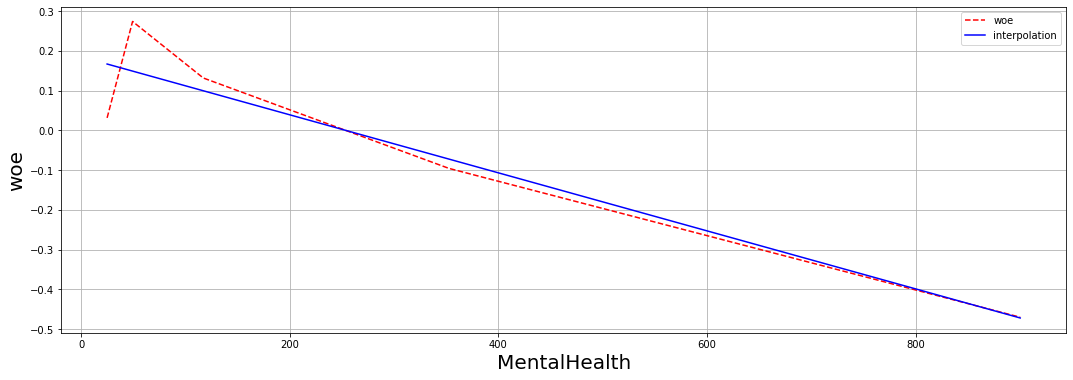

In [ ]:
woe_line((data_train['MentalHealth'].clip(lower=5))**2, y_train, 'MentalHealth', 'HeartDisease')

data_train['MentalHealth_linearized'] = (data_train['MentalHealth'].clip(lower=5))**2

trans_features.append('MentalHealth_linearized')

**SleepTime**

Есть пропуски, заменим значением, при котором woe = 0

SleepTime до линеаризации

feature name : SleepTime
target name : HeartDisease
ROC AUC = 0.51
woe = 0 при SleepTime = 8.0193
IV = 0.073


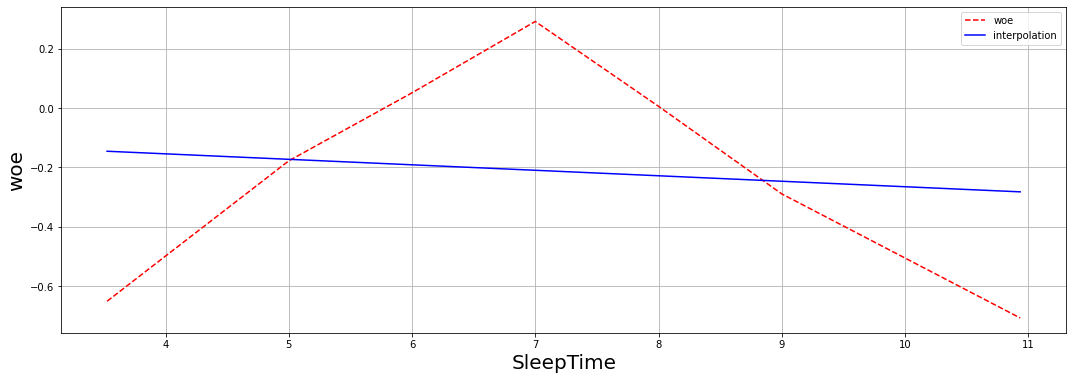

In [ ]:
nan_indexes = np.where(pd.isna(data_train['SleepTime']))[0]

woe_line(data_train['SleepTime'].dropna(), y_train.drop(index=nan_indexes), 'SleepTime', 'HeartDisease')

In [ ]:
data_train['SleepTime_trans'] = data_train['SleepTime'].fillna(8.0193)

SleepTime после линеаризации

feature name : SleepTime_trans
target name : HeartDisease
ROC AUC = 0.52
woe = 0 при SleepTime_trans = 1.7496
IV = 0.019
feature name : SleepTime_trans
target name : HeartDisease
ROC AUC = 0.53
woe = 0 при SleepTime_trans = 2.0805
IV = 0.028


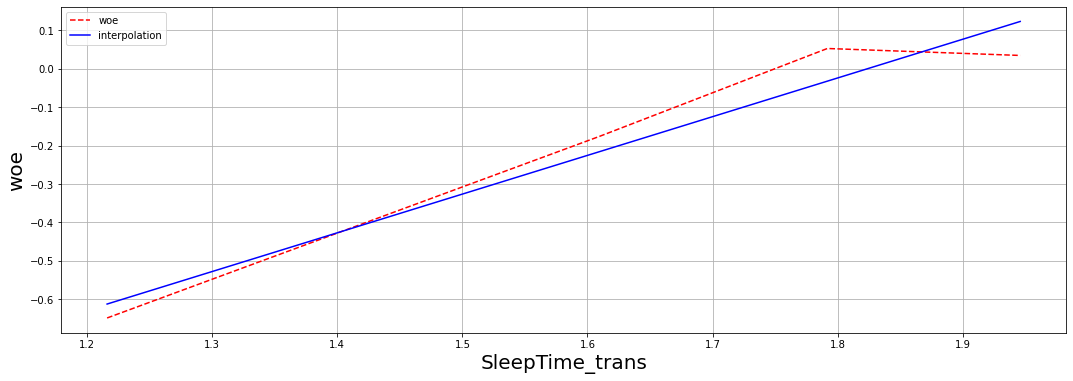

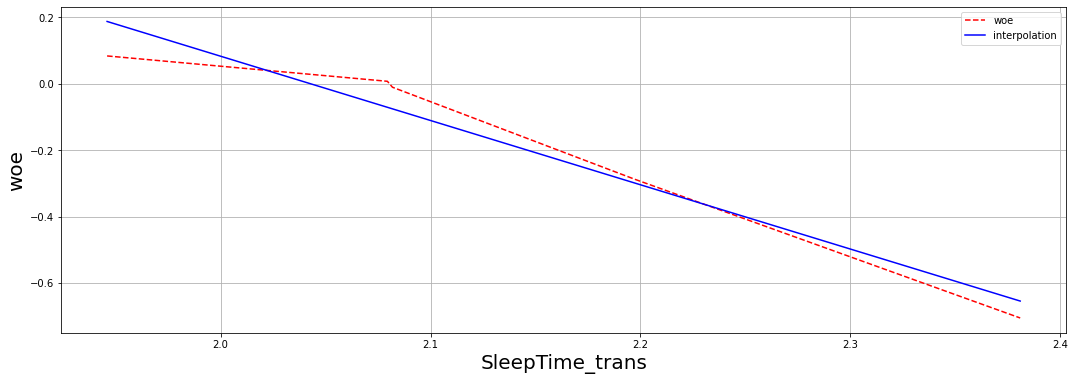

In [ ]:
#заменим на 2 участка линейности, граница = 7 часов

woe_line(np.log(data_train['SleepTime_trans'].clip(upper=7)), y_train, 'SleepTime_trans', 'HeartDisease')

woe_line(np.log(data_train['SleepTime_trans'].clip(lower=7)), y_train, 'SleepTime_trans', 'HeartDisease')

data_train['SleepTime_under_7'] = np.log(data_train['SleepTime_trans'].clip(upper=7))

trans_features.append('SleepTime_under_7')

data_train['SleepTime_over_7'] = np.log(data_train['SleepTime_trans'].clip(lower=7))

trans_features.append('SleepTime_over_7')

**Бинарные признаки**

Бинарные переменные:
1. Smoking - выкурил ли человек за жизнь 100 сигарет
2. AlcoholDrinking - для мужчин: пьет 14 напитков в неделю, для женщин - больше 7
3. Stroke - был ли инсульт
4. DiffWalking - есть ли сложности с ходьбой или поднятием по лестнице
5. Sex - Male / Female
6. PhysicalActivity - в последние 30 дней занимались спортом больше, чем основной работой
7. Asthma - есть/была астма
8. KidneyDisease - были ли болезни почек (кроме камней, ...)
9. SkinCancer - был ли рак кожи

In [ ]:
binary_features = ['Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking', 'Sex', 'PhysicalActivity', 'Asthma', 'KidneyDisease', 'SkinCancer']

data_train[binary_features].isna().any()

Smoking              True
AlcoholDrinking     False
Stroke              False
DiffWalking          True
Sex                 False
PhysicalActivity     True
Asthma               True
KidneyDisease        True
SkinCancer           True
dtype: bool

Обработаем признаки, в которых есть пропуски

Smoking

In [ ]:
data_train['Smoking'].unique()

array(['No', 'Yes', nan, 'White'], dtype=object)

feature name : Smoking_trans
target name : HeartDisease
ROC AUC = 0.59
woe = 0 при Smoking_trans = 0.4912
IV = 0.144


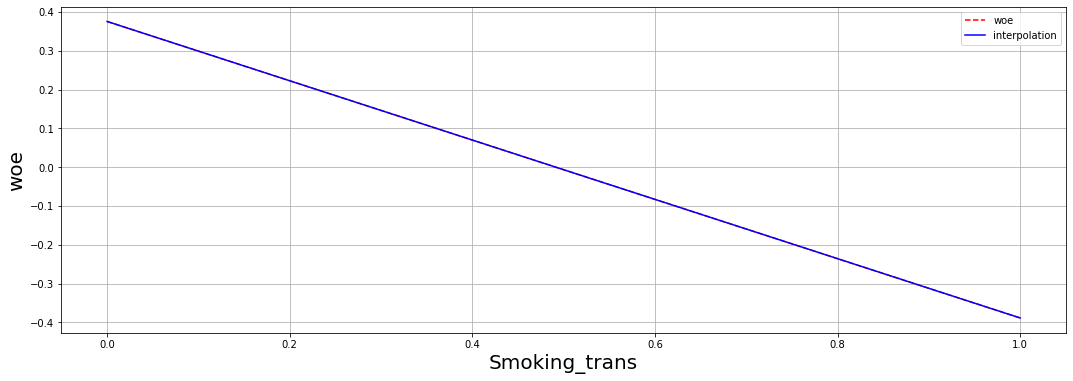

In [ ]:
data_train['Smoking_trans'] = data_train['Smoking'].map({'No': 0, 'Yes': 1, 'White' : np.nan})

nan_indexes = np.where(pd.isna(data_train['Smoking_trans']))[0]

woe_line(data_train['Smoking_trans'].dropna(), y_train.drop(index=nan_indexes), 'Smoking_trans', 'HeartDisease')

In [ ]:
data_train['Smoking_trans'] = data_train['Smoking_trans'].fillna(0.4912)

trans_features.append('Smoking_trans')

DiffWalking

feature name : DiffWalking_trans
target name : HeartDisease
ROC AUC = 0.63
woe = 0 при DiffWalking_trans = 0.2261
IV = 0.370


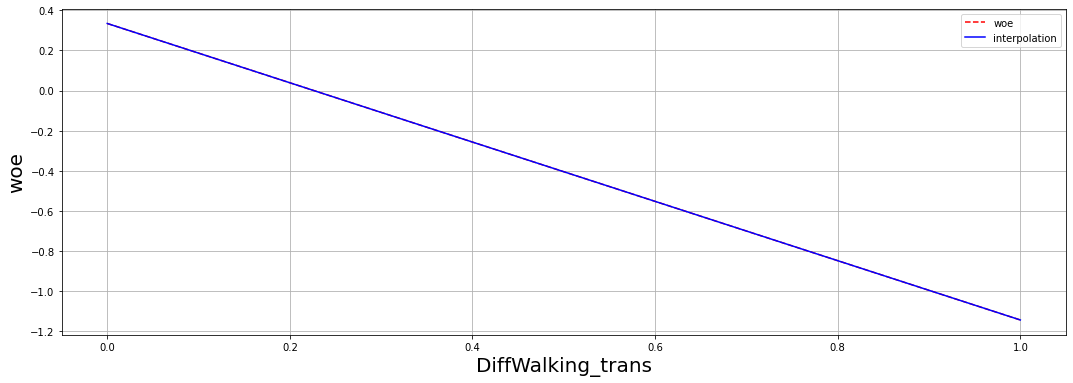

In [ ]:
data_train['DiffWalking_trans'] = data_train['DiffWalking'].map({'No': 0, 'Yes': 1})

nan_indexes = np.where(pd.isna(data_train['DiffWalking_trans']))[0]

woe_line(data_train['DiffWalking_trans'].dropna(), y_train.drop(index=nan_indexes), 'DiffWalking_trans', 'HeartDisease')

In [ ]:
data_train['DiffWalking_trans'] = data_train['DiffWalking_trans'].fillna(0.2261)
trans_features.append('DiffWalking_trans')

PhysicalActivity

feature name : PhysicalActivity_trans
target name : HeartDisease
ROC AUC = 0.57
woe = 0 при PhysicalActivity_trans = 0.7392
IV = 0.105


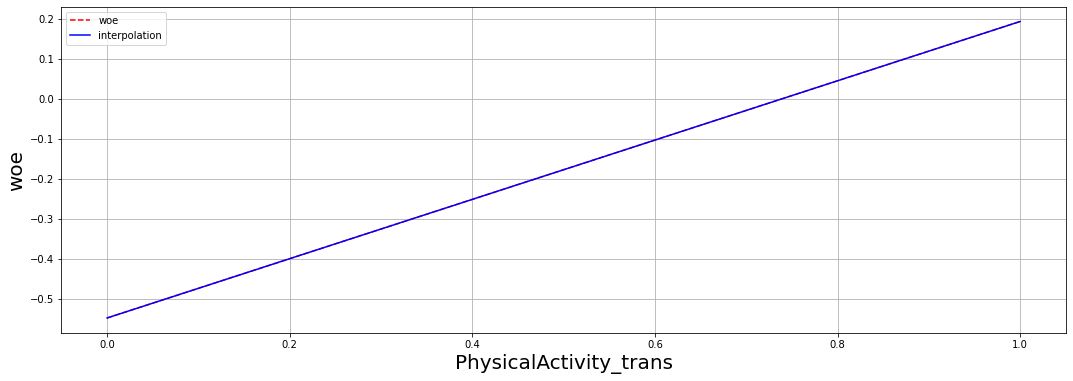

In [ ]:
data_train['PhysicalActivity_trans'] = data_train['PhysicalActivity'].map({'No': 0, 'Yes': 1})

nan_indexes = np.where(pd.isna(data_train['PhysicalActivity_trans']))[0]

woe_line(data_train['PhysicalActivity_trans'].dropna(), y_train.drop(index=nan_indexes), 'PhysicalActivity_trans', 'HeartDisease')

In [ ]:
data_train['PhysicalActivity_trans'] = data_train['PhysicalActivity_trans'].fillna(0.7392)
trans_features.append('PhysicalActivity_trans')

Asthma

feature name : Asthma_trans
target name : HeartDisease
ROC AUC = 0.52
woe = 0 при Asthma_trans = 0.1532
IV = 0.018


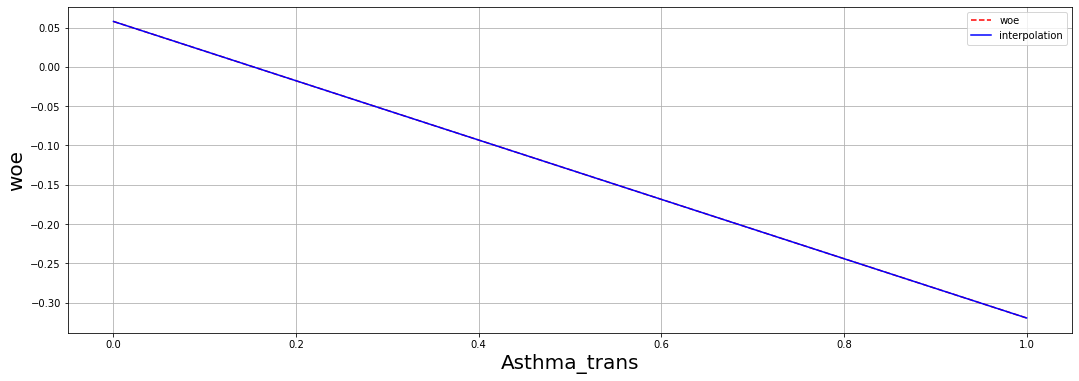

In [ ]:
data_train['Asthma_trans'] = data_train['Asthma'].map({'No': 0, 'Yes': 1})

nan_indexes = np.where(pd.isna(data_train['Asthma_trans']))[0]

woe_line(data_train['Asthma_trans'].dropna(), y_train.drop(index=nan_indexes), 'Asthma_trans', 'HeartDisease')

In [ ]:
data_train['Asthma_trans'] = data_train['Asthma_trans'].fillna(0.1532)
trans_features.append('Asthma_trans')

KidneyDisease 

feature name : KidneyDisease_trans
target name : HeartDisease
ROC AUC = 0.55
woe = 0 при KidneyDisease_trans = 0.0667
IV = 0.160


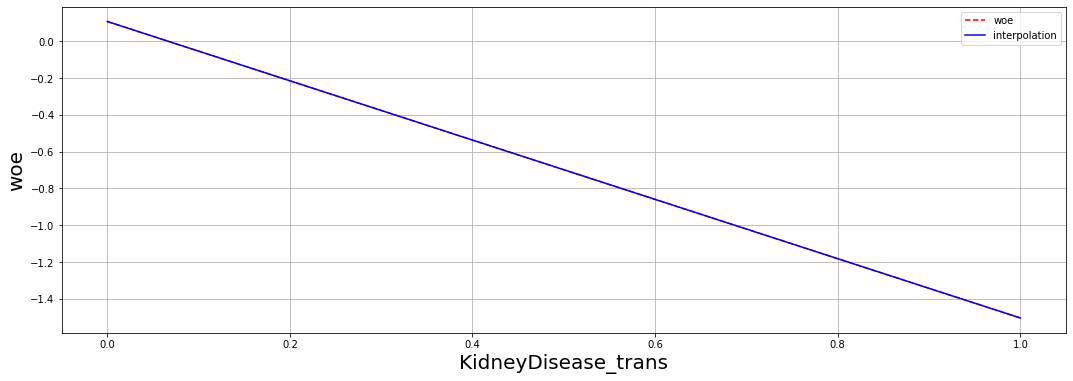

In [ ]:
data_train['KidneyDisease_trans'] = data_train['KidneyDisease'].map({'No': 0, 'Yes': 1})

nan_indexes = np.where(pd.isna(data_train['KidneyDisease_trans']))[0]

woe_line(data_train['KidneyDisease_trans'].dropna(), y_train.drop(index=nan_indexes), 'KidneyDisease_trans', 'HeartDisease')

In [ ]:
data_train['KidneyDisease_trans'] = data_train['KidneyDisease_trans'].fillna(0.0667)
trans_features.append('KidneyDisease_trans')

SkinCancer

feature name : SkinCancer_trans
target name : HeartDisease
ROC AUC = 0.55
woe = 0 при SkinCancer_trans = 0.128
IV = 0.085


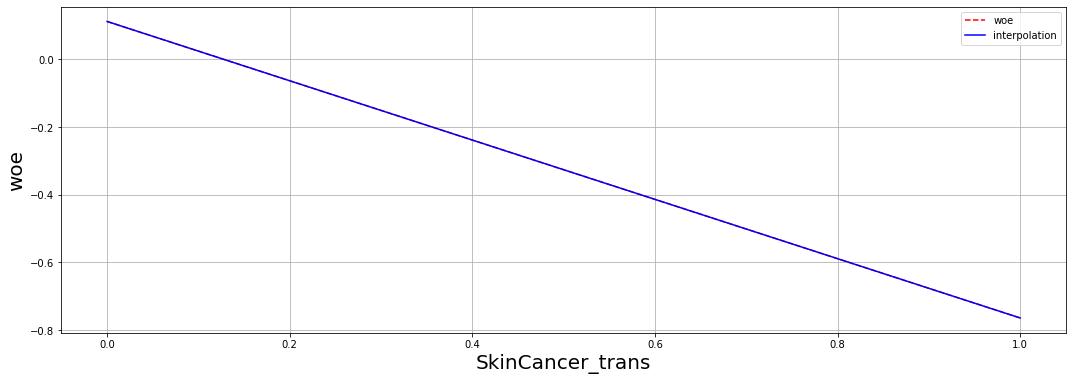

In [ ]:
data_train['SkinCancer_trans'] = data_train['SkinCancer'].map({'No': 0, 'Yes': 1})

nan_indexes = np.where(pd.isna(data_train['SkinCancer_trans']))[0]

woe_line(data_train['SkinCancer_trans'].dropna(), y_train.drop(index=nan_indexes), 'SkinCancer_trans', 'HeartDisease')

In [ ]:
data_train['SkinCancer_trans'] = data_train['SkinCancer_trans'].fillna(0.128)
trans_features.append('SkinCancer_trans')

Stroke, AlcoholDrinking, Sex

In [ ]:
  data_train['Stroke_trans'] = data_train['Stroke'].map({'No': 0, 'Yes': 1})
  data_train['AlcoholDrinking_trans'] = data_train['AlcoholDrinking'].map({'No': 0, 'Yes': 1})
  data_train['Sex_trans'] = data_train['Sex'].map({'No': 0.5299, 'Female' : 0, 'Male': 1}) # воспринимаем 'No' как выброс, woe(0.5299) = 0

Категориальные признаки
1. AgeCategory - возраст
2. Race - раса
3. Diabetic - есть/был диабет (Yes / No / ...)
5. GenHealth - как пациент оценивает свое здоровье

In [ ]:
categorical_features = ['AgeCategory', 'Race', 'Diabetic', 'GenHealth']

data_train[categorical_features].isna().any()

AgeCategory    False
Race            True
Diabetic        True
GenHealth       True
dtype: bool

К AgeCategory применим one-hot encoding. Для этого признака есть категория людей, которые не указали свой возраст, можно воспринимать это как пропуски, в неё попал только 1 респондент, поэтому решил её отбросить.


In [ ]:
data_train['AgeCategory'].value_counts()

65-69          22094
60-64          21793
70-74          19980
55-59          19283
50-54          16489
80 or older    15599
45-49          14108
75-79          13960
40-44          13637
18-24          13595
35-39          13311
30-34          12105
25-29          10889
No                 1
Name: AgeCategory, dtype: int64

In [ ]:
age = pd.get_dummies(data_train.AgeCategory).drop('No', axis=1)

data_train[list(age.columns)] = age

for column in age.columns:
  trans_features.append(column)

Diabetic 

In [ ]:
data_train['Diabetic'].value_counts()

No                         174326
Yes                         26461
No, borderline diabetes      4402
Yes (during pregnancy)       1654
Name: Diabetic, dtype: int64

Я решил объединить диабет во время беременности и пограничный диабет с классом наличия диабета, так как женщины, перенесшие гестационный диабет, и люди с пограничным диабетом находятся в группе с повышенным риском, и соответственно, если рассматривать признак во времени, есть большая вероятность, что люди из этих 2 классов заболеют реальным диабетом.

feature name : Diabetic_trans
target name : HeartDisease
ROC AUC = 0.61
woe = 0 при Diabetic_trans = 0.2388
IV = 0.288


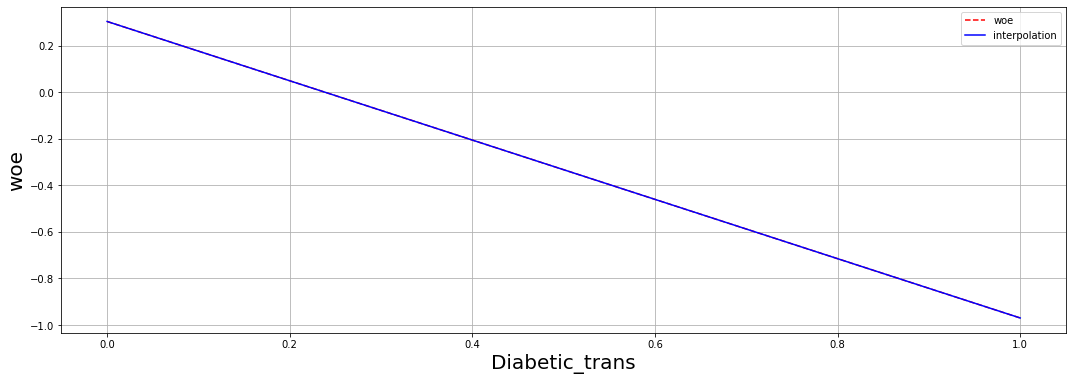

In [ ]:
data_train['Diabetic_trans'] = data_train['Diabetic'].map({'No' : 0, 'Yes' : 1, 'Yes (during pregnancy)' : 1, 'No, borderline diabetes' : 1})

nan_indexes = np.where(pd.isna(data_train['Diabetic_trans']))[0]

woe_line(data_train['Diabetic_trans'].dropna(), y_train.drop(index=nan_indexes), 'Diabetic_trans', 'HeartDisease')

Заменим пропуски значением, при котором woe = 0

In [ ]:
data_train['Diabetic_trans'] = data_train['Diabetic_trans'].fillna(0.2388)
trans_features.append('Diabetic_trans')

GenHealth

Сопоставим оценкам здоровья числовые значения, как будто респондетам предложили оценить общее самочувствие от 1 до 5.

In [ ]:
data_train['GenHealth_trans'] = data_train['GenHealth'].map({'Poor' : 1, 'Fair' : 2, 'Good' : 3, 'Very Good' : 4, 'Excellent' : 5})

feature name : GenHealth_trans
target name : HeartDisease
ROC AUC = 0.72
woe = 0 при GenHealth_trans = 2.9373
IV = 0.819


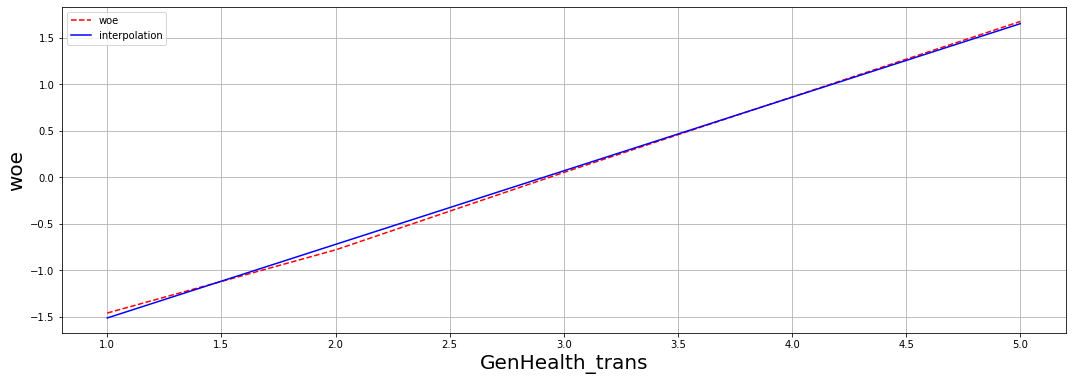

In [ ]:
nan_indexes = np.where(pd.isna(data_train['GenHealth_trans']))[0]

woe_line(data_train['GenHealth_trans'].dropna(), y_train.drop(index=nan_indexes), 'GenHealth_trans', 'HeartDisease')

In [ ]:
data_train['GenHealth_trans'] = data_train['GenHealth_trans'].fillna(3.0)
trans_features.append('GenHealth_trans')

Для Race также воспользуемся one-hot encoding, здесь 3450 пропусков, я отнёс их к категории 'Другие'.

In [ ]:
data_train['Race_trans'] = data_train['Race'].apply(lambda x : 'Other' if pd.isna(x) else x)

race = pd.get_dummies(data_train.Race_trans)

data_train[list(race.columns)] = race

for column in race.columns:
  trans_features.append(column)

#Функция трансформации датасета

Реализуем функцию, которая будет преобразовывать датасет так же, как мы проделали для обучающей выборки. Она нам понадобится для преобразования валидационной и тестовой выборки.

In [ ]:
def feature_transformed(df):
  df['BMI_trans'] = df['BMI'].apply(lambda x : (sum([float(i) for i in x.split('-')]) / 2 if '-' in x else float(x)) if isinstance(x, str) else x)
  df['BMI_linearized'] = np.log(df['BMI_trans']).clip(3.15, 3.5)

  df['PhysicalHealth_trans'] = df['PhysicalHealth'].apply(lambda x : (np.nan if x == 'Fair' else float(x)) if isinstance(x, str) else x)
  df['PhysicalHealth_trans'] = df['PhysicalHealth_trans'].fillna(2.6037)
  df['PhysicalHealth_linearized'] = np.log(df['PhysicalHealth_trans'].clip(lower=1))
  
  df['MentalHealth_linearized'] = (df['MentalHealth'].clip(lower=5))**2

  df['SleepTime_trans'] = df['SleepTime'].fillna(8.0193)
  df['SleepTime_under_7'] = np.log(df['SleepTime_trans'].clip(upper=7))
  df['SleepTime_over_7'] = np.log(df['SleepTime_trans'].clip(lower=7))

  df['Smoking_trans'] = df['Smoking'].map({'No': 0, 'Yes': 1, 'White' : np.nan})
  df['Smoking_trans'] = df['Smoking_trans'].fillna(0.4912)

  df['DiffWalking_trans'] = df['DiffWalking'].map({'No': 0, 'Yes': 1})
  df['DiffWalking_trans'] = df['DiffWalking_trans'].fillna(0.2261)

  df['PhysicalActivity_trans'] = df['PhysicalActivity'].map({'No': 0, 'Yes': 1})
  df['PhysicalActivity_trans'] = df['PhysicalActivity_trans'].fillna(0.7392)

  df['Asthma_trans'] = df['Asthma'].map({'No': 0, 'Yes': 1})
  df['Asthma_trans'] = df['Asthma_trans'].fillna(0.1532)

  df['KidneyDisease_trans'] = df['KidneyDisease'].map({'No': 0, 'Yes': 1})
  df['KidneyDisease_trans'] = df['KidneyDisease_trans'].fillna(0.0667)

  df['SkinCancer_trans'] = df['SkinCancer'].map({'No': 0, 'Yes': 1})
  df['SkinCancer_trans'] = df['SkinCancer_trans'].fillna(0.128)

  age = pd.get_dummies(df.AgeCategory)
  if 'No' in age.columns:
    age.drop('No', axis=1)
  df[list(age.columns)] = age

  df['Diabetic_trans'] = df['Diabetic'].map({'No' : 0, 'Yes' : 1, 'Yes (during pregnancy)' : 1, 'No, borderline diabetes' : 1})
  df['Diabetic_trans'] = df['Diabetic_trans'].fillna(0.2388)

  df['GenHealth_trans'] = df['GenHealth'].map({'Poor' : 1, 'Fair' : 2, 'Good' : 3, 'Very Good' : 4, 'Excellent' : 5})
  df['GenHealth_trans'] = df['GenHealth_trans'].fillna(3.0)

  df['Race_trans'] = df['Race'].apply(lambda x : 'Other' if pd.isna(x) else x)
  race = pd.get_dummies(df.Race_trans)
  df[list(race.columns)] = race

  df['Stroke_trans'] = df['Stroke'].map({'No': 0, 'Yes': 1})
  df['Stroke_trans'] = df['Stroke_trans'].fillna(0.0751) 

  df['AlcoholDrinking_trans'] = df['AlcoholDrinking'].map({'No': 0, 'Yes': 1})
  df['AlcoholDrinking_trans'] = df['AlcoholDrinking_trans'].fillna(0.0537)

  df['Sex_trans'] = df['Sex'].map({'No': 0.5299, 'Female' : 0, 'Male': 1})
  df['Sex_trans'] = df['Sex_trans'].fillna(0.5299)


  return df

#ОБУЧЕНИЕ МОДЕЛИ

Валидационная выборка

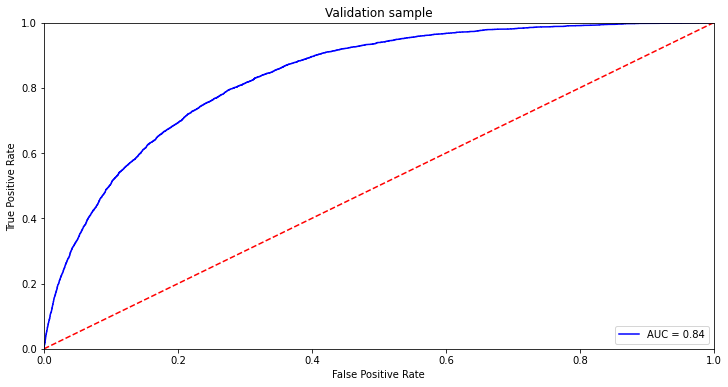

In [ ]:
from sklearn import metrics

model = LogisticRegression(max_iter=3000)

final_features = trans_features + ['Stroke_trans', 'Sex_trans', 'AlcoholDrinking_trans']

X_train = data_train[final_features]

model.fit(X_train, y_train)

X_val = feature_transformed(data_val)

X_val = X_val[final_features]

pred_val = model.predict_proba(X_val)[:, 1]

fpr, tpr, threshold = metrics.roc_curve(y_val, pred_val)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(12, 6))
plt.title('Validation sample')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Тестовая Выборка

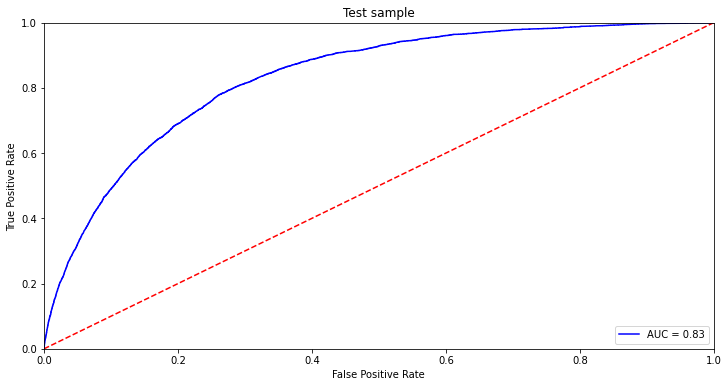

In [ ]:
X_test = feature_transformed(data_test)

X_test_1 = X_test[final_features]

pred_test_1 = model.predict_proba(X_test_1)[:, 1]

fpr, tpr, threshold = metrics.roc_curve(y_test, pred_test_1)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(12, 6))
plt.title('Test sample')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Обучим модель на 9 признаках, имеющих наибольший IV

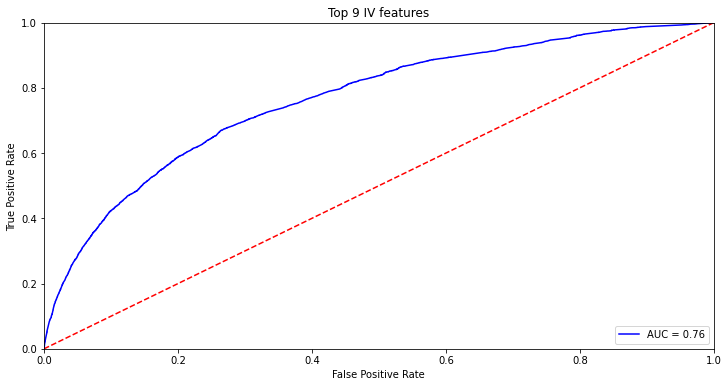

In [ ]:
top_9_IV_features = ['BMI_linearized', 'PhysicalHealth_linearized', 'Smoking_trans', 'Stroke_trans', 'DiffWalking_trans', 'PhysicalActivity_trans', 'KidneyDisease_trans', 'Diabetic_trans', 'GenHealth_trans']

model_new = LogisticRegression(max_iter=3000)

model_new.fit(data_train[top_9_IV_features], y_train)

X_test_2 = X_test[top_9_IV_features]

pred_test_2 = model_new.predict_proba(X_test_2)[:, 1]

fpr, tpr, threshold = metrics.roc_curve(y_test, pred_test_2)
roc_auc = metrics.auc(fpr, tpr)

plt.figure(figsize=(12, 6))
plt.title('Top 9 IV features')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()